<a href="https://colab.research.google.com/github/UPENDRAA09/Machine-Learning/blob/main/Approach_A_Traditional_Machine_Learning_(with_Scikit_learn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approach A: Traditional Machine Learning (with Scikit-learn)
This approach typically involves extracting hand-crafted features from the images.
# 1. Data Loading and Initial Inspection
Python


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog # Popular for traditional ML
from skimage import exposure # For HOG visualization
import matplotlib.pyplot as plt

# Create dummy data directories and files for demonstration
base_dir = "financial_documents_data"
os.makedirs(os.path.join(base_dir, "bank_statements"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "invoices"), exist_ok=True)

# Generate a few dummy images
for i in range(5):
    bs_img = create_dummy_document_image(size=(300, 500)) # Smaller for faster processing
    inv_img = create_dummy_document_image(size=(300, 500))
    cv2.putText(bs_img, "BANK STATEMENT", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    cv2.putText(inv_img, "INVOICE", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    cv2.imwrite(os.path.join(base_dir, "bank_statements", f"bs_{i:03d}.png"), bs_img)
    cv2.imwrite(os.path.join(base_dir, "invoices", f"inv_{i:03d}.png"), inv_img)

# Load image paths and labels
image_paths = []
labels = []
for label_name in ["bank_statements", "invoices"]:
    label_dir = os.path.join(base_dir, label_name)
    for img_name in os.listdir(label_dir):
        image_paths.append(os.path.join(label_dir, img_name))
        labels.append(label_name)

print(f"Total images found: {len(image_paths)}")
print(f"Sample labels: {labels[:5]}")

# Encode labels to numerical format
le = LabelEncoder()
numerical_labels = le.fit_transform(labels)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Label mapping: {label_mapping}")


Total images found: 10
Sample labels: ['bank_statements', 'bank_statements', 'bank_statements', 'bank_statements', 'bank_statements']
Label mapping: {np.str_('bank_statements'): np.int64(0), np.str_('invoices'): np.int64(1)}


In [3]:
def create_dummy_document_image(size=(600, 800), color=(255, 255, 255)):
    """Creates a blank dummy image representing a document."""
    img = np.full((*size, 3), color, dtype=np.uint8)
    return img

# 2. Pre-processing Pipeline Function
This function will encapsulate the common pre-processing steps.
Python

Shape of processed images (X): (10, 128, 128)
Shape of labels (y): (10,)


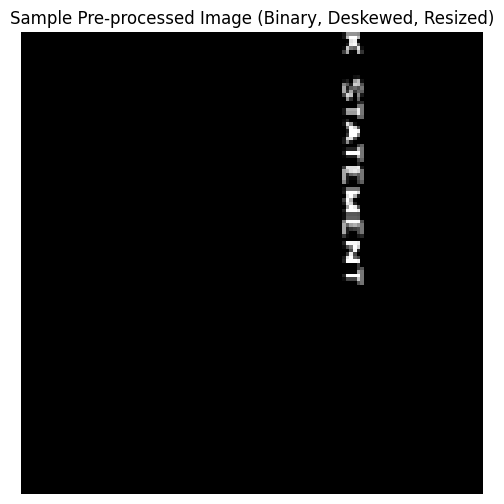

In [7]:

def preprocess_document_image(image_path, target_size=(128, 128)):
    """
    Applies a series of OpenCV pre-processing steps to a document image.
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired output size (width, height).
    Returns:
        np.array: Processed image array.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}. Skipping.")
        return None

    # Step 1: Deskew (using the function defined earlier)
    img_deskewed, _ = deskew_image(img) # Returns the deskewed image and angle
    # The deskewed image might have different dimensions, so we resize it afterwards.

    # Step 2: Convert to Grayscale
    gray = cv2.cvtColor(img_deskewed, cv2.COLOR_BGR2GRAY)

    # Step 3: Noise Reduction (Median Blur is good for scanned docs)
    denoised = cv2.medianBlur(gray, 5)

    # Step 4: Binarization (Adaptive Thresholding for varying light)
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    # Invert binary if text is black on white (typical for documents)
    binary = cv2.bitwise_not(binary) # Text becomes white, background black

    # Step 5: Resize to target size for feature extraction
    # Ensure it's resized last to maintain consistent input to feature extractor
    processed_image = cv2.resize(binary, target_size, interpolation=cv2.INTER_AREA)

    return processed_image

# Apply pre-processing to all images
processed_images = []
processed_labels = []
for i, path in enumerate(image_paths):
    processed_img = preprocess_document_image(path)
    if processed_img is not None:
        processed_images.append(processed_img)
        processed_labels.append(numerical_labels[i])

X = np.array(processed_images)
y = np.array(processed_labels)

print(f"Shape of processed images (X): {X.shape}") # (num_samples, height, width)
print(f"Shape of labels (y): {y.shape}") # (num_samples,)

# Show a sample pre-processed image
if len(X) > 0:
    show_image("Sample Pre-processed Image (Binary, Deskewed, Resized)", X[0])


In [6]:
import math

def deskew_image(image):
    """
    Corrects the skew of a document image.
    Args:
        image (np.array): Input image array.
    Returns:
        tuple: A tuple containing the deskewed image array and the calculated angle.
    """
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Invert the image (assuming text is black on white)
    gray = cv2.bitwise_not(gray)

    # Thresholding to get a binary image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours (optional, but can help focus on text areas)
    # contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # You could potentially use the orientation of the largest contour

    # Find coordinates of non-zero pixels
    coords = np.column_stack(np.where(thresh > 0))

    # Find the minimum area bounding box of the non-zero pixels
    angle = cv2.minAreaRect(coords)[-1]

    # The angle returned by minAreaRect is in the range [-90, 0).
    # Adjust the angle based on the box orientation
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Get the rotation matrix
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform the rotation
    deskewed = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return deskewed, angle

def show_image(title, img):
    """Displays an image using matplotlib."""
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

3. Feature Extraction (Traditional ML - HOG)
Here, we'll extract Histogram of Oriented Gradients (HOG) features, which are popular for shape and texture information.
Python


In [8]:
# Function to extract HOG features
def extract_hog_features(image):
    # HOG parameters (can be tuned)
    # orientations: number of bins for orientation
    # pixels_per_cell: size of the cell (px, px)
    # cells_per_block: size of the block (cells, cells)
    # transform_sqrt: apply power law compression (gamma correction) to normalize pixel values
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    return features

# Extract features for all pre-processed images
features_list = []
for img in X:
    features_list.append(extract_hog_features(img))

X_features = np.array(features_list)
print(f"Shape of extracted features (X_features): {X_features.shape}") # (num_samples, num_features)


Shape of extracted features (X_features): (10, 8100)


# 4. Model Training (Traditional ML - Support Vector Machine)
Python


In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

print(f"Train features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Initialize and train a Support Vector Machine classifier
print("\nTraining SVM Classifier...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42) # 'linear' kernel often good for text-based features
svm_model.fit(X_train, y_train)
print("Training complete.")

# Make predictions
y_pred = svm_model.predict(X_test)


Train features shape: (8, 8100)
Test features shape: (2, 8100)

Training SVM Classifier...
Training complete.


# 5. Model Evaluation
Python


In [10]:
print("\n--- SVM Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Note: With only 10 dummy images, evaluation metrics will be highly unreliable.
# For real-world scenarios, you need hundreds or thousands of images per class.



--- SVM Model Evaluation ---
Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

bank_statements       1.00      1.00      1.00         1
       invoices       1.00      1.00      1.00         1

       accuracy                           1.00         2
      macro avg       1.00      1.00      1.00         2
   weighted avg       1.00      1.00      1.00         2


Confusion Matrix:
[[1 0]
 [0 1]]


# 6. Prediction on New Data
Python

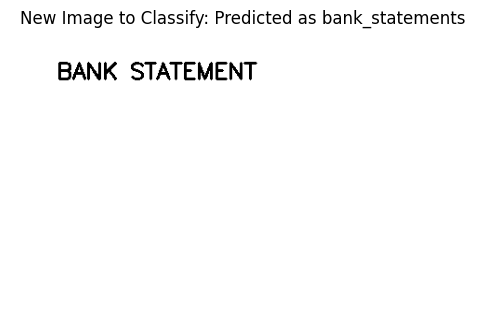


Predicted class for bs_001.png: bank_statements


In [11]:

# Load a new unseen image (e.g., one of the dummy images, or a new one)
new_image_path = os.path.join(base_dir, "bank_statements", "bs_001.png") # Example path

# Pre-process the new image
unseen_processed_img = preprocess_document_image(new_image_path)
if unseen_processed_img is None:
    print("Could not process the new image.")
else:
    # Extract features
    unseen_features = extract_hog_features(unseen_processed_img)
    unseen_features = unseen_features.reshape(1, -1) # Reshape for single prediction

    # Make prediction
    prediction = svm_model.predict(unseen_features)
    predicted_class = le.inverse_transform(prediction)[0]

    show_image(f"New Image to Classify: Predicted as {predicted_class}", cv2.imread(new_image_path))
    print(f"\nPredicted class for {os.path.basename(new_image_path)}: {predicted_class}")

# Clean up dummy data (optional)
# import shutil
# if os.path.exists(base_dir):
#     shutil.rmtree(base_dir)
